In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from IPython.display import HTML
from matplotlib import pyplot as plt

from hyperfit.linfit import LinFit

In [2]:
df = pd.read_csv('SMBH_Data_0407.csv',header=1)

In [3]:
## useful functions
def x2name(feature_list,df_handson):
    for ind in feature_list:
        i=int(ind[1:])
        print('x',i,':',df_handson.columns[i])

def rmse(y,y_pred,w):
    return np.sqrt(np.average((y-y_pred)**2,weights=w))

def df2name(df):
    for i in range(len(df.columns)):
        print('x',i,':',df.columns[i])
        
def test_relation(paras,obs=pd.read_csv('SMBH_Data_0303.csv',header=1),
                  operator='simp',ncyclesperiteration=550,niterations=40,denoise=False,adaptive_parsimony_scaling=20,
                  verbosity=0,colname=False):
    
    if paras[-1]!='M_BH':
        paras.append('M_BH')
        
    paras.append('M_BH_std')
    
    obs = obs[paras].dropna(axis='index',how='any')
    print(len(obs))
    
    
    y = obs['M_BH'].to_numpy()
    w = 1/obs['M_BH_std'].to_numpy()**2

    #df_handson = df
    if colname:
        X = obs.iloc[:,:-2]
    else:
        X = obs.iloc[:,:-2].to_numpy()
        #X = df_handson

    if operator=='adv':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/","pow"],
            unary_operators=["exp","log10"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )
    if operator=='simp':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/", "pow"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )
        
    if operator=='basic':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )



    model.fit(X=X, y=y, weights=w)

    print('parameters:')
    df2name(obs.iloc[:,:-2])
    
    print('Eq. selected rmse:',rmse(y,model.predict(X),w))
    display(model.sympy())
    
    for i in range(len(model.equations_)):
        print('Eq.',i,'rmse:',rmse(y,model.predict(X,index=i),w))
        display(model.sympy(index=i))

In [4]:
test_relation(['log_sigma0'],operator='basic')

143


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


parameters:
x 0 : log_sigma0
Eq. selected rmse: 0.40721024333969297


5.4007153049711105*x0 - 4.03741404249618

Eq. 0 rmse: 0.9931469144722266


8.065674313377025

Eq. 1 rmse: 0.5065752656080431


3.609150601058027*x0

Eq. 2 rmse: 0.40721024333969297


5.4007153049711105*x0 - 4.03741404249618

Eq. 3 rmse: 0.39528073597078867


1.2046328935347197*x0**2 + 1.9819373485610796

Eq. 4 rmse: 0.39288957930640594


1.5488571426597093*x0**2 - 1.5488571426597093*x0 + 3.7145208280149213

Eq. 5 rmse: 0.3878431130504752


x0**2*(0.7302300396271838*x0 - 1.502750791102893) + x0 + 5.06053172344499

Eq. 6 rmse: 0.3878261237623796


x0**2*(0.7302300381836665*x0 - 1.5027507861598206) + x0 + 5.056901554105558

Eq. 7 rmse: 0.38782023883025524


x0**2*(0.8813241024823197*x0 - 2.4600227724560717) + 3*x0 + 3.6801774305000747

In [9]:
def fit(paras,bounds,plot=True):
    paras.append('M_BH')
    stds=[]
    for para in paras:
        stds.append(para+'_std')
    
    df_=df[paras+stds].dropna(axis='index',how='any')
    xs=np.array(df_[paras]).transpose()
    errs=np.array(df_[stds]).transpose()
    cov=np.zeros((len(paras),len(paras),len(df_)))
    for i in range(len(paras)):
        cov[i,i,:]=errs[i]**2

    hf = LinFit(xs, cov)

    mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=False)
    print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))
    
    
    if plot:
        c=np.mean(mcmc_samples, axis=1)
        y=xs[-1]
        y_pred=0
        for i in range(len(c)-2):
            y_pred+=c[i]*xs[i]
        y_pred+=c[-2]

    plt.figure(figsize=(8,6))
    plt.scatter(y,y_pred,label='predicted')
    plt.plot(np.linspace(y_pred.min(),y_pred.max()),np.linspace(y_pred.min(),y_pred.max()),label='f(x)=x')
    plt.xlabel(r'True $\rm{log} M_{BH}$',fontsize=20)
    plt.ylabel(r'Predicted $\rm{log} M_{BH}$',fontsize=20)
    plt.legend()
    plt.show()
    
    w = 1/errs[-1]**2
    print('rmse:',np.sqrt(np.average((y-y_pred)**2,weights=w)))
    return np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1)

/home/zj448/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


[ 5.39254382 -4.0642592   0.52647037] [0.05985942 0.11927627 0.03842892]


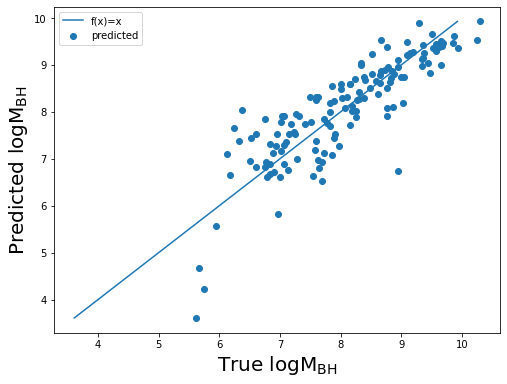

rmse: 0.4138335159250941


(array([ 5.39254382, -4.0642592 ,  0.52647037]),
 array([0.05985942, 0.11927627, 0.03842892]))

In [7]:
fit(paras=['log_sigma0'],bounds = ((5.3, 5.5),(-4.1, -3.9), (1.0e-5, 1.0)),plot=True)

In [8]:
def m_sigma_relation(log_sigma0):    
    a=5.39254382
    b=-4.0642592
    return a*(log_sigma0)+b

In [9]:
def rmse(y,y_pred):
    return np.sqrt(np.average((y-y_pred)**2))

def wrmse(y,y_pred,w):
    return np.sqrt(np.average((y-y_pred)**2,weights=w))

def plot_relation(paras,relation,obs=pd.read_csv('SMBH_Data_0303.csv',header=1)):
    if paras[-1]!='M_BH':
        paras.append('M_BH')
        
    paras.append('M_BH_std')
    
    obs = obs[paras].dropna(axis='index',how='any')
    
    print(len(obs))
    
    y=obs['M_BH'].to_numpy()
    yerr=obs['M_BH_std'].to_numpy()
    
    x=[]
    for i in range(len(paras)-2):
        x.append(obs.iloc[:,i].to_numpy())
    
    y_pred=relation(*x)
    
    # f(x)=x line
    minrange=np.array([y.min(),y_pred.min()]).min()
    maxrange=np.array([y.max(),y_pred.max()]).max()
    fs=20
    plt.figure(figsize=(12,8))
    plt.plot(np.linspace(minrange,maxrange),np.linspace(minrange,maxrange),label='f(x)=x',c='r',ls='--')
    #plt.scatter(y,y_pred,label='Observations',alpha=0.8)
    plt.errorbar(y,y_pred,xerr=yerr,label='Observations',alpha=0.8,fmt='o',capsize=3,ecolor='grey')
    
    plt.xlabel(r'True $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    plt.ylabel(r'Predicted $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    plt.legend(fontsize=fs)
    plt.show()
    
    w = 1/yerr**2
    print('obs rmse:',rmse(y,y_pred))
    print('obs wrmse:',wrmse(y,y_pred,w))

143


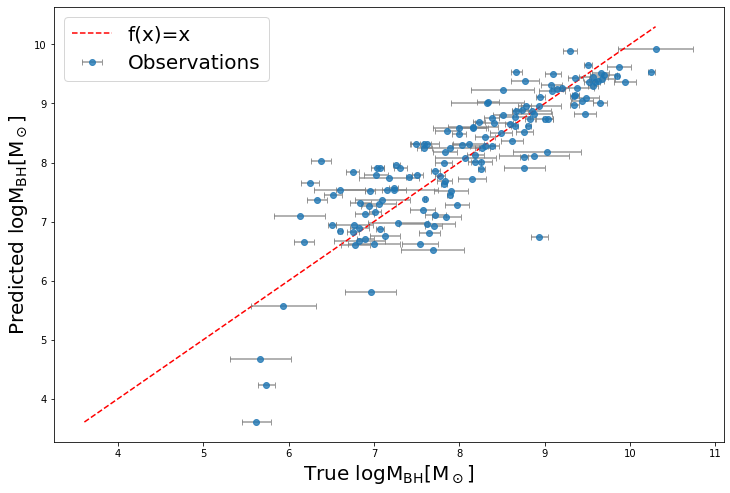

obs rmse: 0.5840556830016451
obs wrmse: 0.4097087600942304


In [10]:
plot_relation(['log_sigma0'],m_sigma_relation)